<a href="https://colab.research.google.com/github/joaquim-teixeira/metabolite-gfl/blob/main/Paper_Final_Model_Implementations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount into drive
# Mount into drive
from google.colab import drive
drive.mount("/content/drive")
%cd '/content/drive/MyDrive/'
!pip install noise

Mounted at /content/drive
/content/drive/MyDrive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for noise: filename=noise-1.2.2-cp312-cp312-linux_x86_64.whl size=56630 sha256=2c5509a417cb1e67b93b64ec19043ad0684338437079e767d6557cda93cc607a
  Stored in directory: /root/.cache/pip/wheels/78/71/a2/47a0c6acdeb8f7a2f4e69067d3c737219e36414136441a1ef8
Successfully built noise


In [2]:
sim_name = 'big_circle_'

You are using device: cuda


/tmp/ipython-input-83062454.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lods = torch.tensor(lods, dtype=torch.double)


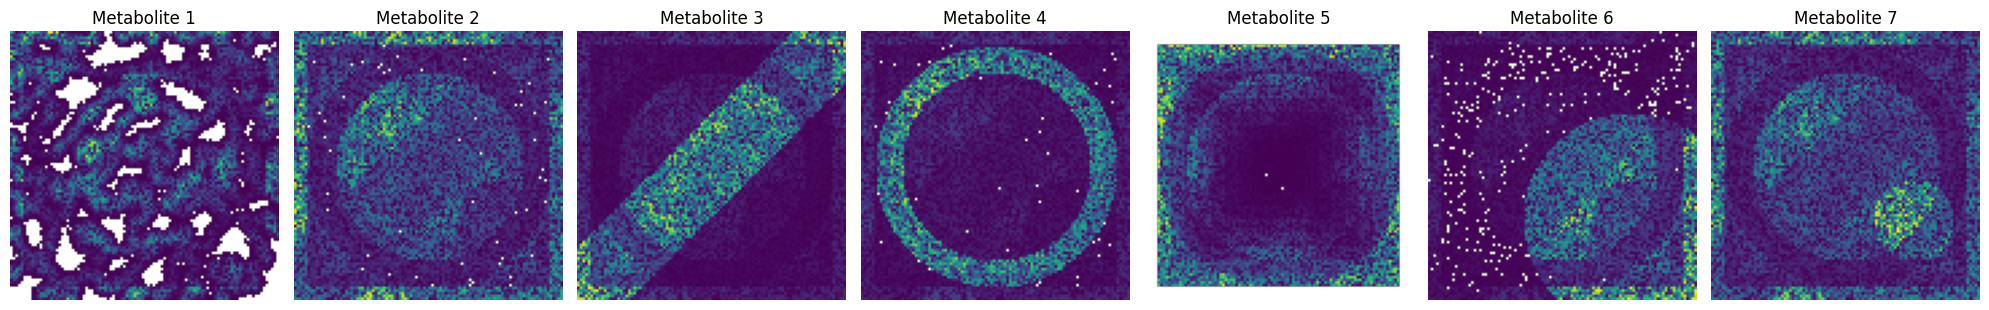

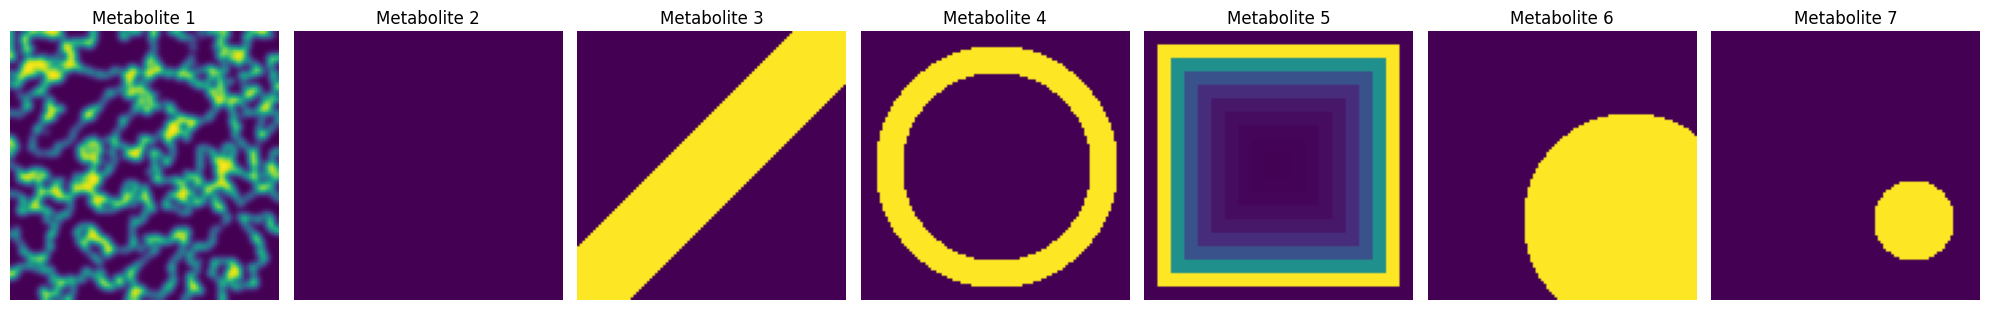

Percentage Censored: tensor(0.0519)


/tmp/ipython-input-83062454.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lv2.append(torch.tensor(lov).to(device))


In [5]:
#@title Simulating Metabolites
'''
Description:
Generate a simulated 2D field with 7 overlapping metabolites,
including censoring at metabolite-specific Limits of Detection (LODs).
'''

# Allow duplicate OpenMP libraries to avoid crashes
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Standard scientific and plotting libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import torch.nn.functional as F
from torch.distributions import Dirichlet, Multinomial, Laplace, Gamma, InverseGamma, Normal, MultivariateNormal
import time
import scipy as sp
from scipy.spatial import KDTree
from scipy.ndimage import gaussian_filter

# For Perlin noise (used to simulate vein-like metabolite)
from noise import pnoise2

# Set reproducible seed for torch
torch.manual_seed(238)

# Choose device: GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

# ---------------------------------------------
# Helper functions
# ---------------------------------------------

def perlin_vein_pattern(size, scale=10.0, octaves=6, threshold=0.1):
    """
    Generate a vein-like pattern using Perlin noise and a threshold.

    Args:
        size (tuple): Height and width of the pattern.
        scale (float): Controls frequency of noise.
        octaves (int): Number of noise layers to sum.
        threshold (float): Narrow band around zero-crossing to define veins.

    Returns:
        np.array: Smoothed vein pattern.
    """
    H, W = size
    pattern = np.zeros((H, W))
    for y in range(H):
        for x in range(W):
            n = pnoise2(x / scale, y / scale, octaves=octaves)
            if abs(n) < threshold:  # narrow band around zero crossing
                pattern[y, x] = 1.0
    # Smooth the pattern to make veins more natural
    return gaussian_filter(pattern, sigma=1.2)


def sample_neg_mult_gamma_cont(n, p, size):
    """
    Approximate negative multinomial sampling using gamma and normal distributions.

    Args:
        n (Tensor): Gamma shape parameter.
        p (Tensor): Probabilities of categories.
        size (int): Number of samples.

    Returns:
        Tensor: Sampled counts (continuous approximation).
    """
    p0 = 1 - p.sum(axis=-1)
    n_sample = torch.distributions.Gamma(n, 1/(1/(p0 + 1e-40)-1) + 1e-40).rsample([size])
    val = (n_sample / (1 - p0 + 1e-40)).unsqueeze(-1) * p.unsqueeze(0)
    tst = torch.distributions.Normal(val, torch.sqrt(val + 1e-40)).rsample()
    return tst


def find_neighbors(points, threshold):
    """
    Use KDTree to find neighbors within a distance threshold.

    Args:
        points (ndarray): Coordinates of points.
        threshold (float): Distance threshold for neighbors.

    Returns:
        list: List of neighbor indices for each point.
    """
    tree = KDTree(points)
    neighbors = tree.query_ball_tree(tree, threshold)
    return neighbors


def create_adjacency_matrix(points, neighbors):
    """
    Convert neighbor list to adjacency matrix (symmetric).

    Args:
        points (ndarray): Points coordinates.
        neighbors (list): Neighbor indices from KDTree.

    Returns:
        ndarray: NxN adjacency matrix of 0/1 connections.
    """
    n = len(points)
    adjacency_matrix = np.zeros((n, n), dtype=int)
    for i, neighbor_list in enumerate(neighbors):
        for neighbor in neighbor_list:
            adjacency_matrix[i][neighbor] = 1
            adjacency_matrix[neighbor][i] = 1
    return adjacency_matrix


def multinomial_rvs(count, p):
    """
    Sample counts from a multinomial distribution.

    Args:
        count (ndarray): Total counts per sample.
        p (ndarray): Probability vectors per sample.

    Returns:
        ndarray: Multinomial samples per category.
    """
    out = np.zeros(p.shape, dtype=int)
    count = count.copy()
    ps = p.cumsum(axis=-1)
    with np.errstate(divide='ignore', invalid='ignore'):
        condp = p / ps
    condp[np.isnan(condp)] = 0.0
    for i in range(p.shape[-1]-1, 0, -1):
        binsample = np.random.binomial(count, condp[..., i])
        out[..., i] = binsample
        count -= binsample
    out[..., 0] = count
    return out

# ---------------------------------------------
# Generate latent "truth" metabolite field
# ---------------------------------------------
D = 7  # number of metabolites
size = 100  # grid size

truth = np.zeros((size, size, D))  # latent metabolite rates

# Example metabolite 2 uniform base intensity
truth[:, :, 1] = 5

# Metabolite 6: circular region with higher intensity
for i in range(truth.shape[0]):
    for j in range(truth.shape[1]):
        dist = np.abs(np.sqrt((i - size//2 - 20)**2 + (j - size//2 - 25)**2))
        truth[i,j,5] += 50 if dist < 40 else 5

# Metabolite 7: smaller, more intense circular region
for i in range(truth.shape[0]):
    for j in range(truth.shape[1]):
        dist = np.abs(np.sqrt((i - size//2 - 20)**2 + (j - size//2 - 25)**2))
        truth[i,j,6] += 200 if dist < 15 else 50

# Metabolite 3: diagonal band with tapered intensities
for i in range(100):
    for j in range(100):
        truth[i,j,2] = 100 if np.abs(i+j-99)<20 else 10

# Metabolite 5: concentric "layers" from center
center = size // 2
for i in reversed(range(10)):
    truth[(center-i*5):(center+i*5), (center-i*5):(center+i*5), 4] = (2**i)/2

# Metabolite 4: circular shell with high intensity
for i in range(truth.shape[0]):
    for j in range(truth.shape[1]):
        dist = np.abs(np.sqrt((i - size//2)**2 + (j - size//2)**2))
        truth[i,j,3] += 300 if 15 < dist < 45 else 15
        truth[i,j,3] = 15 if dist < 15 else truth[i,j,3]

# Metabolite 1: vein-like pattern
truth[:, :, 0] = perlin_vein_pattern((size, size), scale=15.0, octaves=4, threshold=0.05) * 100.

# ---------------------------------------------
# Construct adjacency matrix of the grid
# ---------------------------------------------
x_vals = np.arange(0, size)
y_vals = np.arange(0, size)
X, Y = np.meshgrid(x_vals, y_vals)
grid_points = np.vstack([X.ravel(), Y.ravel()]).T

neighbors = find_neighbors(grid_points, 1.5)
adj_matrix = create_adjacency_matrix(grid_points, neighbors)
adj_matrix = torch.from_numpy(adj_matrix) - torch.eye(len(grid_points))  # remove self-loops
adj = (adj_matrix == 1).nonzero()  # get edge indices

# ---------------------------------------------
# Generate counts with censoring
# ---------------------------------------------
N_max = 1e7
N_min = 1e5
n_obs = np.random.randint(N_min, N_max, truth.shape[:-1])  # total counts per pixel

# Sample multinomial counts using latent truth probabilities
data = multinomial_rvs(np.full(truth.shape[:-1], n_obs, dtype=int),
                       truth / truth.sum(axis=-1, keepdims=True))

# Normalize for plotting / proportions
tic_data = data / data.sum(axis=-1, keepdims=True)

# Convert to torch tensors
data = torch.from_numpy(data).to(torch.float64).reshape(size*size, D)

# Define random LODs (per metabolite)
lods = torch.randint(int(.001*N_max), size=[D]).unsqueeze(0).expand([data.size(0), -1]).double()

# Create censoring masks
cens = (data < lods)
cens_row = cens.float()
data[cens] = 0  # set censored values to zero

# Prepare a masked version with NaNs for plotting
d2 = data.clone().reshape(size, size, D)
d2[cens] = torch.nan

# Plot simulated metabolite fields
fig, axs = plt.subplots(1, D, figsize=(20, 3))
for i in range(D):
    axs[i].imshow(d2[:, :, i])
    axs[i].set_title(f"Metabolite {i+1}")
    axs[i].axis('off')
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, D, figsize=(20, 3))
for i in range(D):
    axs[i].imshow(truth[:, :, i])
    axs[i].set_title(f"Metabolite {i+1}")
    axs[i].axis('off')
plt.tight_layout()
plt.show()

# Process censoring information for ELBO calculation
cr, ct, lv = [], [], [0]
p = 0
for i in range(0, data.size(1)):
    if ((cens_row.sum(axis=1) == i).sum() > 0):
        cr.append(cens_row.sum(axis=1) == i)
        ct.append(((cens.float()) * (cr[p].float()).unsqueeze(1)).to(torch.bool))
        temp = lods[ct[i]]
        if i > 0:
            lv.append(temp.reshape([int(temp.size(0)/i), i]))
        p += 1

# Masks for number of censored metabolites per pixel
cens_row_2 = (cens_row.sum(axis=1) > 1)
cens_row_1 = (cens_row.sum(axis=1) == 1)
cens_row_0 = (cens_row.sum(axis=1) == 0)

cens1 = ((cens.float()) * (cens_row_1.float()).unsqueeze(1)).to(torch.bool)
cens2 = ((cens.float()) * (cens_row_2.float()).unsqueeze(1)).to(torch.bool)

# Ensure unique edges
edges_sorted = torch.sort(adj, dim=1)[0]
edges_unique = torch.unique(edges_sorted, dim=0)

# Compute differences across adjacency edges (for lasso penalty)
delta = torch.abs(data[adj[:,0]] - data[adj[:,1]])
print('Percentage Censored:', cens.float().mean())

# Move LODs and other tensors to device
lv = [torch.tensor(lv_i).to(device) for lv_i in lv]
lods = lods.to(device)
cens_inf = cens.clone().float()
cens_inf[cens] = torch.inf

# Convert original truth to float tensor
tst = torch.tensor(truth, dtype=torch.float32).to(device)


In [6]:
#@title Negative Multinomial Sampling and HVGFL ELBO

def sample_neg_mult_gamma_cont_cens(n, p, size, cens):
    """
    Sample from a negative multinomial-like distribution using a continuous gamma approximation,
    accounting for censoring.

    Args:
        n (Tensor): Shape parameter for the gamma distribution.
        p (Tensor): Probability vector for categories.
        size (int): Number of samples to generate.
        cens (Tensor): Censoring mask (1 if observed, 0 if censored).

    Returns:
        Tensor: Sampled values of shape [size, ...] matching input dimensions.
    """
    # Compute adjusted probability of zero-count based on censoring
    p0 = 1 - (p * cens).sum(axis=-1)

    # Sample latent counts from a gamma distribution approximating negative multinomial
    # The transformation 1/(1/(p0) - 1) is a parameterization trick to get desired mean
    n_sample = torch.distributions.Gamma(n, 1/(1/(p0 + 1e-40) - 1) + 1e-40).rsample([size])

    # Scale by censored probabilities and reshape to match dimensions
    val = (n_sample / (1 - p0 + 1e-40)).unsqueeze(-1) * (p * cens).unsqueeze(0)

    # Introduce Gaussian noise to approximate continuous counts
    tst = torch.distributions.Normal(val, torch.sqrt(val + 1e-40)).rsample()

    return tst


def elbo_lasso_cens(theta_q_loc, x, lam, adj, cens, lods, cr, samp_size, n_samp,
                    cens_exp, gamma_1_raw, gamma_2_raw, lam_1_raw, lam_2_raw,
                    dat_exp, a1, a2, cens_inf):
    """
    Computes the Evidence Lower Bound (ELBO) for a Hierarchical Variational Graph-Fused Lasso (HVGFL)
    model with censored negative multinomial data.

    Args:
        theta_q_loc (Tensor): Variational mean for theta logits.
        x (Tensor): Observed data.
        lam (float): Hyperparameter for gamma prior on lambda.
        adj (Tensor): Adjacency pairs for graph-fused lasso.
        cens (Tensor): Censoring mask.
        lods (Tensor): Limit of detection values for censored observations.
        cr (Tensor): Mask for completely observed data.
        samp_size (int): Number of negative multinomial samples per observation.
        n_samp (int): Number of variational samples.
        cens_exp (Tensor): Mask for censored entries.
        gamma_1_raw, gamma_2_raw (Tensor): Raw parameters for gamma variational distributions.
        lam_1_raw, lam_2_raw (Tensor): Raw parameters for gamma variational distributions of lambda.
        dat_exp (Tensor): Observed counts or exposures.
        a1, a2 (Tensor): Indices used to accumulate sums for precision computation.
        cens_inf (Tensor): Large constant to stabilize softmax for censored data.

    Returns:
        Tensor: Scalar ELBO value.
    """

    # Construct variational distributions for local and global scale parameters
    q_lam = torch.distributions.Gamma(torch.exp(lam_1_raw), torch.exp(lam_2_raw))
    lam_samp = q_lam.rsample([n_samp])

    q_gamma = torch.distributions.Gamma(torch.exp(gamma_1_raw), torch.exp(gamma_2_raw))
    q_gamma_samp = q_gamma.rsample([n_samp])

    # Determine shapes and prepare accumulators
    p1, E, q = q_gamma_samp.shape
    N = adj.max().item() + 1
    sums = torch.zeros(p1, N, q, dtype=torch.float32, device=device)

    # Compute sum of inverse gamma samples for precision of variational theta
    sums.scatter_add_(1, a1, 1 / q_gamma_samp)
    sums.scatter_add_(1, a2, 1 / q_gamma_samp)

    # Construct variational normal distribution for theta logits
    theta_q = torch.distributions.Normal(theta_q_loc, (1 / sums).sqrt())
    samps_q = theta_q.rsample([1]).squeeze(0)

    # Apply softmax to get probabilities
    theta = torch.softmax(samps_q, dim=-1)

    # Sample censored negative multinomial values for non-completely observed data
    wot = sample_neg_mult_gamma_cont_cens(dat_exp.sum(axis=-1)[:, ~cr],
                                          theta[:, ~cr, :],
                                          samp_size,
                                          cens_exp[:, ~cr, :])

    # Soft indicator for censoring likelihood contribution
    soft_indicator = torch.sigmoid(1e5 * (lods[~cr] - wot))
    vals = (((torch.sigmoid(1e5 * (soft_indicator.mean(axis=-1) - 1))) * 2.).mean(axis=0) + 1e-90).log()

    # Compute log-likelihood for observed (non-censored) data
    log_theta = samps_q - torch.logsumexp(samps_q - cens_inf, axis=-1).unsqueeze(-1)
    log_likelihood = (dat_exp[~cens_exp] * log_theta[~cens_exp]).sum() / n_samp
    log_likelihood = log_likelihood + vals.sum(axis=1).mean()

    # Graph-fused lasso prior: encourage neighboring differences to be small
    mu = (samps_q[:, adj[:, 0], :] - samps_q[:, adj[:, 1], :]).unsqueeze(0)
    laplace_prior = -(((mu.abs() * (1 / q_gamma_samp.unsqueeze(1))).sum([-1, -2])).mean())

    # Local gamma prior contribution
    local_prior = -(q_gamma_samp / lam_samp.unsqueeze(1)).sum([-1, -2]).mean()

    # Entropy terms for variational distributions
    ent_gamma = q_gamma.log_prob(q_gamma_samp).sum([-1, -2]).mean()
    ent_norm = theta_q.log_prob(samps_q).sum([-1, -2]).mean()

    # KL divergence between variational and prior for lambda
    lam_prior = torch.distributions.Gamma(1, lam)
    lam_kl = torch.distributions.kl_divergence(q_lam, lam_prior)

    return log_likelihood + laplace_prior + local_prior - ent_norm - ent_gamma - lam_kl.sum()


In [8]:
#@title Run HVGFL
import torch
import matplotlib.pyplot as plt
import time

# Prepare and flatten the data
data = data.reshape(size * size, D).to(torch.float32).to(device)
pd = data.clone()  # keep a copy for initialization
lam_use = data.mean(axis=0).cpu()  # used to initialize gamma/lambda parameters

# Initialize variational parameters
theta_q_loc = torch.tensor(
    ((pd + 1) / (pd + D).sum(axis=1, keepdims=True)).log(),
    device=device, requires_grad=True
)
gamma_1_raw = torch.ones((edges_unique.size(0), data.size(1)), device=device, requires_grad=True)
gamma_2_raw = torch.ones((edges_unique.size(0), data.size(1)), device=device) * lam_use.log()
gamma_2_raw.requires_grad_(True)
lam_1_raw = torch.zeros_like(lam_use, device=device, requires_grad=True)
lam_2_raw = torch.ones_like(lam_use, device=device) * lam_use.log()
lam_2_raw.requires_grad_(True)
lam_group = data.var(axis=0).to(device)

# Expand tensors for multiple variational samples
dat_exp = data.unsqueeze(0).expand(n_samp, -1, -1)
cens_exp = cens.unsqueeze(0).expand(n_samp, -1, -1)
a1 = edges_unique[:, 0].unsqueeze(0).unsqueeze(-1).expand(n_samp, -1, D)
a2 = edges_unique[:, 1].unsqueeze(0).unsqueeze(-1).expand(n_samp, -1, D)

# Set up the optimizer
optimizer = torch.optim.Adam(
    [theta_q_loc, gamma_1_raw, gamma_2_raw, lam_1_raw, lam_2_raw], lr=0.01
)
losses = []

for step in tqdm(range(num_steps)):
    optimizer.zero_grad()
    # Compute negative ELBO for censored data
    loss = -elbo_lasso_cens(
        theta_q_loc, data, lam_group, edges_unique, cens, lods, cr[0],
        samp_size, n_samp, cens_exp, gamma_1_raw, gamma_2_raw,
        lam_1_raw, lam_2_raw, dat_exp, a1, a2, cens_inf
    )
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    # Monitor performance
    if step != 0 and step % 5000 == 0:
        print(f"Step {step}")
        # Flatten and normalize data using TIC
        gdata = data.clone()
        gdata[cens] = torch.nan
        tic = gdata / gdata.nansum(dim=1, keepdims=True)

        # Normalize true rates
        vs = torch.tensor(truth.reshape(size*size, D)) / torch.mean(truth, dim=0)

        # Sample gamma posterior and compute adjacency-based precision sums
        q_gamma = torch.distributions.Gamma(gamma_1_raw.exp(), gamma_2_raw.exp())
        q_gamma_samp = q_gamma.sample([100])
        tsums = torch.zeros(100, edges_unique.max().item() + 1, D, device=device)
        tsums.scatter_add_(1, a1[:100], 1/q_gamma_samp)
        tsums.scatter_add_(1, a2[:100], 1/q_gamma_samp)

        # Sample theta posterior and compute quantiles
        q_theta = torch.distributions.Normal(theta_q_loc, (1 / tsums.unsqueeze(0)).sqrt())
        samps_q = q_theta.sample([1]).squeeze(0).flatten(0,1)
        quants = torch.quantile(
            samps_q.exp()/torch.mean(samps_q.exp(), dim=1, keepdims=True),
            q=torch.tensor([0.05,0.25,0.5,0.75,0.95], device=device),
            dim=0
        )

        # Compute RMSE and credible interval coverage
        rmse_tic = (tic - vs.to(device)).pow(2).mean(axis=0).sqrt()
        rmse_VI = (quants[2] - vs.to(device)).pow(2).mean(axis=0).sqrt()
        CI_50 = ((vs <= quants[3])*(vs >= quants[1])).sum(axis=0)/(size*size)
        CI_90 = ((vs <= quants[4])*(vs >= quants[0])).sum(axis=0)/(size*size)

        print("RMSE TIC:", rmse_tic, "RMSE Posterior Median:", rmse_VI)
        print("50% CI coverage:", CI_50, "90% CI coverage:", CI_90)
        print("Average 90% CI width:", (quants[4] - quants[0]).mean(axis=0))

# Optional: save model checkpoint
'''
torch.save({
    'step': step,
    'theta_q_loc': theta_q_loc.detach().cpu(),
    'gamma_1_raw': gamma_1_raw.detach().cpu(),
    'gamma_2_raw': gamma_2_raw.detach().cpu(),
    'lam_1_raw': lam_1_raw.detach().cpu(),
    'lam_2_raw': lam_2_raw.detach().cpu(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss.item()
}, outfile_name)
'''


/tmp/ipython-input-1443999526.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_q_loc = torch.tensor(((pd+1)/(pd+D).sum(axis=1,keepdims=True)).log().clone().to(torch.float32),device=device,requires_grad=True)
/tmp/ipython-input-1443999526.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gamma_1_raw = torch.tensor(torch.ones((edges_unique.size(0),data.size(1)), dtype=torch.float32)*(1.),device=device,requires_grad=True)
/tmp/ipython-input-1443999526.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gamma_2_raw = torch.tenso

10000
RMSE for TIC:  tensor([1.2231, 0.9784, 1.2212, 1.4747, 1.2911, 1.2719, 0.9551],
       device='cuda:0', dtype=torch.float64)
RMSE for Posterior Median:  tensor([0.1553, 0.1132, 0.1712, 0.0969, 0.0898, 0.1864, 0.1463],
       device='cuda:0', dtype=torch.float64)
50% Credible Interval Coverage:  tensor([0.0147, 0.0075, 0.0000, 0.0091, 0.0068, 0.0002, 0.0000],
       device='cuda:0')
90% Credible Interval Coverage:  tensor([0.0558, 0.0220, 0.0000, 0.0211, 0.0168, 0.0009, 0.0005],
       device='cuda:0')
tensor([0.0403, 0.0290, 0.0111, 0.0117, 0.0133, 0.0139, 0.0107],
       device='cuda:0')


 60%|█████▉    | 14998/25000 [02:44<01:50, 90.77it/s]/tmp/ipython-input-1443999526.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  truth = torch.tensor(truth)
 60%|██████    | 15008/25000 [02:44<01:57, 84.71it/s]

15000
RMSE for TIC:  tensor([1.2231, 0.9784, 1.2212, 1.4747, 1.2911, 1.2719, 0.9551],
       device='cuda:0', dtype=torch.float64)
RMSE for Posterior Median:  tensor([0.0249, 0.0060, 0.0051, 0.0071, 0.0075, 0.0063, 0.0051],
       device='cuda:0', dtype=torch.float64)
50% Credible Interval Coverage:  tensor([0.5034, 0.6606, 0.4004, 0.3902, 0.3362, 0.4185, 0.3710],
       device='cuda:0')
90% Credible Interval Coverage:  tensor([0.7525, 0.9783, 0.8028, 0.7839, 0.6421, 0.8156, 0.7778],
       device='cuda:0')
tensor([0.0403, 0.0281, 0.0108, 0.0111, 0.0132, 0.0131, 0.0102],
       device='cuda:0')


 80%|████████  | 20018/25000 [03:39<00:51, 96.46it/s]

20000
RMSE for TIC:  tensor([1.2231, 0.9784, 1.2212, 1.4747, 1.2911, 1.2719, 0.9551],
       device='cuda:0', dtype=torch.float64)
RMSE for Posterior Median:  tensor([0.0249, 0.0056, 0.0051, 0.0057, 0.0060, 0.0053, 0.0039],
       device='cuda:0', dtype=torch.float64)
50% Credible Interval Coverage:  tensor([0.5195, 0.6977, 0.4911, 0.4711, 0.3918, 0.5344, 0.4826],
       device='cuda:0')
90% Credible Interval Coverage:  tensor([0.7484, 0.9860, 0.8842, 0.8678, 0.6885, 0.9161, 0.8761],
       device='cuda:0')
tensor([0.0401, 0.0280, 0.0108, 0.0111, 0.0132, 0.0131, 0.0102],
       device='cuda:0')


100%|██████████| 25000/25000 [04:33<00:00, 91.40it/s]


"\noutfile_name = sim_name + 'Full_model_simulation.pt'\n\ntorch.save({\n'step': step,\n'theta_q_loc': theta_q_loc.detach().cpu(),\n'gamma_1_raw': gamma_1_raw.detach().cpu(),\n'gamma_2_raw': gamma_2_raw.detach().cpu(),\n'lam_1_raw': lam_1_raw.detach().cpu(),\n'lam_2_raw': lam_2_raw.detach().cpu(),\n'optimizer_state_dict': optimizer.state_dict(),\n'loss': loss.item()\n}, outfile_name)\n"

In [ ]:
#@title Save HVGFL

outfile_name = sim_name + 'Full_model_simulation.pt'

torch.save({
'step': step,
'theta_q_loc': theta_q_loc.detach().cpu(),
'gamma_1_raw': gamma_1_raw.detach().cpu(),
'gamma_2_raw': gamma_2_raw.detach().cpu(),
'lam_1_raw': lam_1_raw.detach().cpu(),
'lam_2_raw': lam_2_raw.detach().cpu(),
'optimizer_state_dict': optimizer.state_dict(),
'loss': loss.item()
}, outfile_name)


In [ ]:
#@title ELBO for Mean-Field VI

def elbo_lasso_cens_simple_MF(theta_q_loc, x, lam, adj, cens, lods, cr, samp_size, n_samp,
                              cens_exp, lam_1_raw, lam_2_raw, dat_exp, cens_inf, theta_q_sd):
    """
    Computes the Evidence Lower Bound (ELBO) for a Mean-Field Variational Inference
    version of the Graph-Fused Lasso model with censored negative multinomial data.

    Args:
        theta_q_loc (Tensor): Variational mean for theta logits.
        x (Tensor): Observed data (counts).
        lam (float or Tensor): Hyperparameter for the Gamma prior on lambda.
        adj (Tensor): Adjacency pairs for graph-fused lasso penalty.
        cens (Tensor): Mask indicating censored observations.
        lods (Tensor): Limit-of-detection values for censored entries.
        cr (Tensor): Mask for completely observed data points.
        samp_size (int): Number of negative multinomial samples for censored data.
        n_samp (int): Number of Monte Carlo samples from variational distributions.
        cens_exp (Tensor): Expanded censoring mask aligned with dat_exp.
        lam_1_raw (Tensor): Raw variational parameter for lambda shape (on log scale).
        lam_2_raw (Tensor): Raw variational parameter for lambda rate (on log scale).
        dat_exp (Tensor): Expanded observed data tensor (replicated for sampling).
        cens_inf (Tensor): Large constant for stabilizing softmax under censoring.
        theta_q_sd (Tensor): Log standard deviation parameter for variational Normal over logits.

    Returns:
        Tensor: Scalar ELBO estimate.
    """

    q_lam = torch.distributions.Gamma(torch.exp(lam_1_raw), torch.exp(lam_2_raw))
    lam_samp = q_lam.rsample([n_samp])

    theta_q = torch.distributions.Normal(theta_q_loc, torch.exp(theta_q_sd))
    samps_q = theta_q.rsample([n_samp])
    theta = torch.softmax(samps_q, dim=-1)

    wot = sample_neg_mult_gamma_cont_cens(dat_exp.sum(axis=-1)[:, ~cr],
                                          theta[:, ~cr, :],
                                          samp_size,
                                          cens_exp[:, ~cr, :])
    soft_indicator = torch.sigmoid(1e5 * (lods[~cr] - wot))
    vals = (((torch.sigmoid(1e5 * (soft_indicator.mean(axis=-1) - 1))) * 2.).mean(axis=0) + 1e-90).log()

    log_theta = samps_q - torch.logsumexp(samps_q - cens_inf, axis=-1).unsqueeze(-1)
    log_likelihood = (dat_exp[~cens_exp] * log_theta[~cens_exp]).sum() / n_samp
    log_likelihood = log_likelihood + vals.sum(axis=1).mean()

    mu = (samps_q[:, adj[:, 0], :] - samps_q[:, adj[:, 1], :]).unsqueeze(0)
    laplace_prior = -(((mu.abs() * (1 / lam_samp.unsqueeze(1))).sum([-1, -2])).mean())

    ent_norm = theta_q.log_prob(samps_q).sum([-1, -2]).mean()

    lam_prior = torch.distributions.Gamma(1, lam)
    lam_kl = torch.distributions.kl_divergence(q_lam, lam_prior)

    return log_likelihood + laplace_prior - ent_norm - lam_kl.sum()



In [ ]:
import torch
import matplotlib.pyplot as plt
import time
#@title Run Mean-Field VI w/o Gamma-Lasso
# Example reshaping
data = data.reshape(size * size, D).to(device)
scales =  [1000*1, 1000*10, 1000*100]
data = data.reshape(size*size,D)
data = data.to(torch.float32)
pd = data.clone()
lam_use = data.mean(axis=0).cpu()

theta_q_loc = torch.tensor(((pd+1)/(pd+D).sum(axis=1,keepdims=True)+1e-3).log().clone().to(torch.float32),device=device,requires_grad=True)
theta_q_sd = torch.tensor(torch.ones_like(data)*.5,device=device,requires_grad=True)



lam_1_raw = torch.zeros_like(lam_use,device=device, requires_grad=True)
lam_2_raw = torch.tensor(torch.ones_like(lam_use,dtype=torch.float64)*lam_use.log(),device=device, requires_grad=True)
lam_group = data.var(axis=0)
# --- Setup & Optimization ---
num_steps = 25000
samp_size = 100
n_samp = 2
losses = []

data = data.to(device)
cens = cens.to(device)
cens_inf = cens_inf.to(device)
edges_unique = edges_unique.to(device)
cr = [x.to(device) for x in cr]
ct = [x.to(device) for x in ct]
dat_exp = data.unsqueeze(0).expand(n_samp, -1, -1).to(device)
cens_exp = cens.unsqueeze(0).expand(n_samp, -1, -1).to(device)

lam_group = lam_group.to(device)

N = edges_unique.max().item() + 1
optimizer = torch.optim.Adam([theta_q_loc, lam_1_raw, lam_2_raw, theta_q_sd], lr=0.01)
# --- Training Loop ---
TH = 1e12
for step in range(num_steps):
    optimizer.zero_grad()

    loss = -elbo_lasso_cens_simple_MF(
        theta_q_loc=theta_q_loc, x=data, lam=lam_group, adj=edges_unique,
        cens=cens, lods=lods, cr=cr[0],
        samp_size=samp_size, n_samp=n_samp, cens_exp=cens_exp,
        lam_1_raw=lam_1_raw, lam_2_raw=lam_2_raw, dat_exp=dat_exp,  cens_inf = cens_inf,theta_q_sd=theta_q_sd)

    loss.backward()

    optimizer.step()

    losses.append(loss.item())
    with torch.no_grad():
      if step !=0:
        if step != 5000:
          if step % 5000 == 0:
            print(step)
            val = np.average(losses[-5000:])
            if val>TH:
              print('technically converged')

            TH = val
            data=data.reshape(size*size,D)
            truth = truth.reshape (size*size,D)
            gdata=data.clone()
            gdata[cens]=torch.nan
            tic=gdata/gdata.nansum(dim=1,keepdims=True)
            truth = torch.tensor(truth)
            vs = truth/torch.mean(truth,dim=0)



            q_theta = torch.distributions.Normal(theta_q_loc,theta_q_sd.exp())

            samps_q = q_theta.sample([100])
            quants = torch.quantile((samps_q.exp()/torch.mean(samps_q.exp(), dim = (1),keepdims=True)),q=torch.tensor([0.05,0.25,0.5,0.75,0.95], dtype=torch.float32,device=device), dim=0)


            alpha = quants[2]
            gdata=data.clone()
            gdata[cens] = lods[cens].to(dtype=torch.float32)/2
            tic=gdata/gdata.nansum(dim=1,keepdims=True)
            tic2=tic/torch.nanmean(tic,dim=0)
            vs = vs.to(device)
            rmse_tic = (tic2-vs).pow(2).mean(axis=[0]).sqrt()

            rmse_VI = (quants[2]-vs).pow(2).mean(axis=[0]).sqrt()
            print("RMSE for TIC: ", rmse_tic)
            print ("RMSE for Posterior Median: ", rmse_VI)
            CI_50 = ((vs<=quants[3])*(vs>=quants[1])).sum(axis=0)/(size*size)
            print("50% Credible Interval Coverage: ", CI_50)
            CI_90 = ((vs<=quants[4])*(vs>=quants[0])).sum(axis=0)/(size*size)
            print("90% Credible Interval Coverage: ", CI_90)
            print ((quants[4] - quants[0]).mean(axis=0))
outfile_name = sim_name + 'Simple_MF_model_simulation.pt'
torch.save({
'step': step,
'theta_q_loc': theta_q_loc.detach().cpu(),
'lam_1_raw': lam_1_raw.detach().cpu(),
'lam_2_raw': lam_2_raw.detach().cpu(),
'theta_q_sd': theta_q_sd.detach().cpu(),
'optimizer_state_dict': optimizer.state_dict(),
'loss': loss.item()
}, outfile_name)

<ipython-input-87-1bba22c4ec2e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_q_loc = torch.tensor(((pd+1)/(pd+D).sum(axis=1,keepdims=True)+1e-3).log().clone().to(torch.float32),device=device,requires_grad=True)
<ipython-input-87-1bba22c4ec2e>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_q_sd = torch.tensor(torch.ones_like(data)*.5,device=device,requires_grad=True)
<ipython-input-87-1bba22c4ec2e>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lam_2_raw = torch.tensor(torch.ones_like(lam_use,dtype=torch.float64)*lam

10000
RMSE for TIC:  tensor([1.1912, 0.9733, 1.1844, 1.3999, 1.1051, 1.2506, 0.9149],
       device='cuda:0', dtype=torch.float64)
RMSE for Posterior Median:  tensor([0.2876, 0.1906, 0.1442, 0.2868, 0.2225, 0.1967, 0.2739],
       device='cuda:0', dtype=torch.float64)
50% Credible Interval Coverage:  tensor([0.1624, 0.0905, 0.0859, 0.0707, 0.0465, 0.1506, 0.1355],
       device='cuda:0')
90% Credible Interval Coverage:  tensor([0.3617, 0.2021, 0.2161, 0.1887, 0.1218, 0.3422, 0.3157],
       device='cuda:0')
tensor([0.2244, 0.1028, 0.0891, 0.0842, 0.0814, 0.1495, 0.1372],
       device='cuda:0')


<ipython-input-87-1bba22c4ec2e>:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  truth = torch.tensor(truth)


15000
RMSE for TIC:  tensor([1.1912, 0.9733, 1.1844, 1.3999, 1.1051, 1.2506, 0.9149],
       device='cuda:0', dtype=torch.float64)
RMSE for Posterior Median:  tensor([0.0980, 0.0489, 0.0275, 0.0980, 0.0573, 0.0447, 0.0952],
       device='cuda:0', dtype=torch.float64)
50% Credible Interval Coverage:  tensor([0.1371, 0.0215, 0.0410, 0.0572, 0.0133, 0.0913, 0.0859],
       device='cuda:0')
90% Credible Interval Coverage:  tensor([0.3142, 0.0508, 0.1015, 0.1352, 0.0303, 0.2047, 0.2185],
       device='cuda:0')
tensor([0.0718, 0.0089, 0.0103, 0.0120, 0.0077, 0.0223, 0.0150],
       device='cuda:0')
20000
RMSE for TIC:  tensor([1.1912, 0.9733, 1.1844, 1.3999, 1.1051, 1.2506, 0.9149],
       device='cuda:0', dtype=torch.float64)
RMSE for Posterior Median:  tensor([0.0685, 0.0065, 0.0105, 0.0307, 0.0101, 0.0259, 0.0490],
       device='cuda:0', dtype=torch.float64)
50% Credible Interval Coverage:  tensor([0.1114, 0.0233, 0.0127, 0.0125, 0.0286, 0.0191, 0.0000],
       device='cuda:0')
90% Cre

<ipython-input-92-043255bda413>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  truth = torch.tensor(truth)


RMSE for TIC:  tensor([0.5256, 0.5131, 0.4008, 0.4460, 0.5908, 0.5684, 0.6235],
       device='cuda:0', dtype=torch.float64)
RMSE for Posterior Median:  tensor([0.0673, 0.0047, 0.0091, 0.0281, 0.0088, 0.0237, 0.0469],
       dtype=torch.float64)


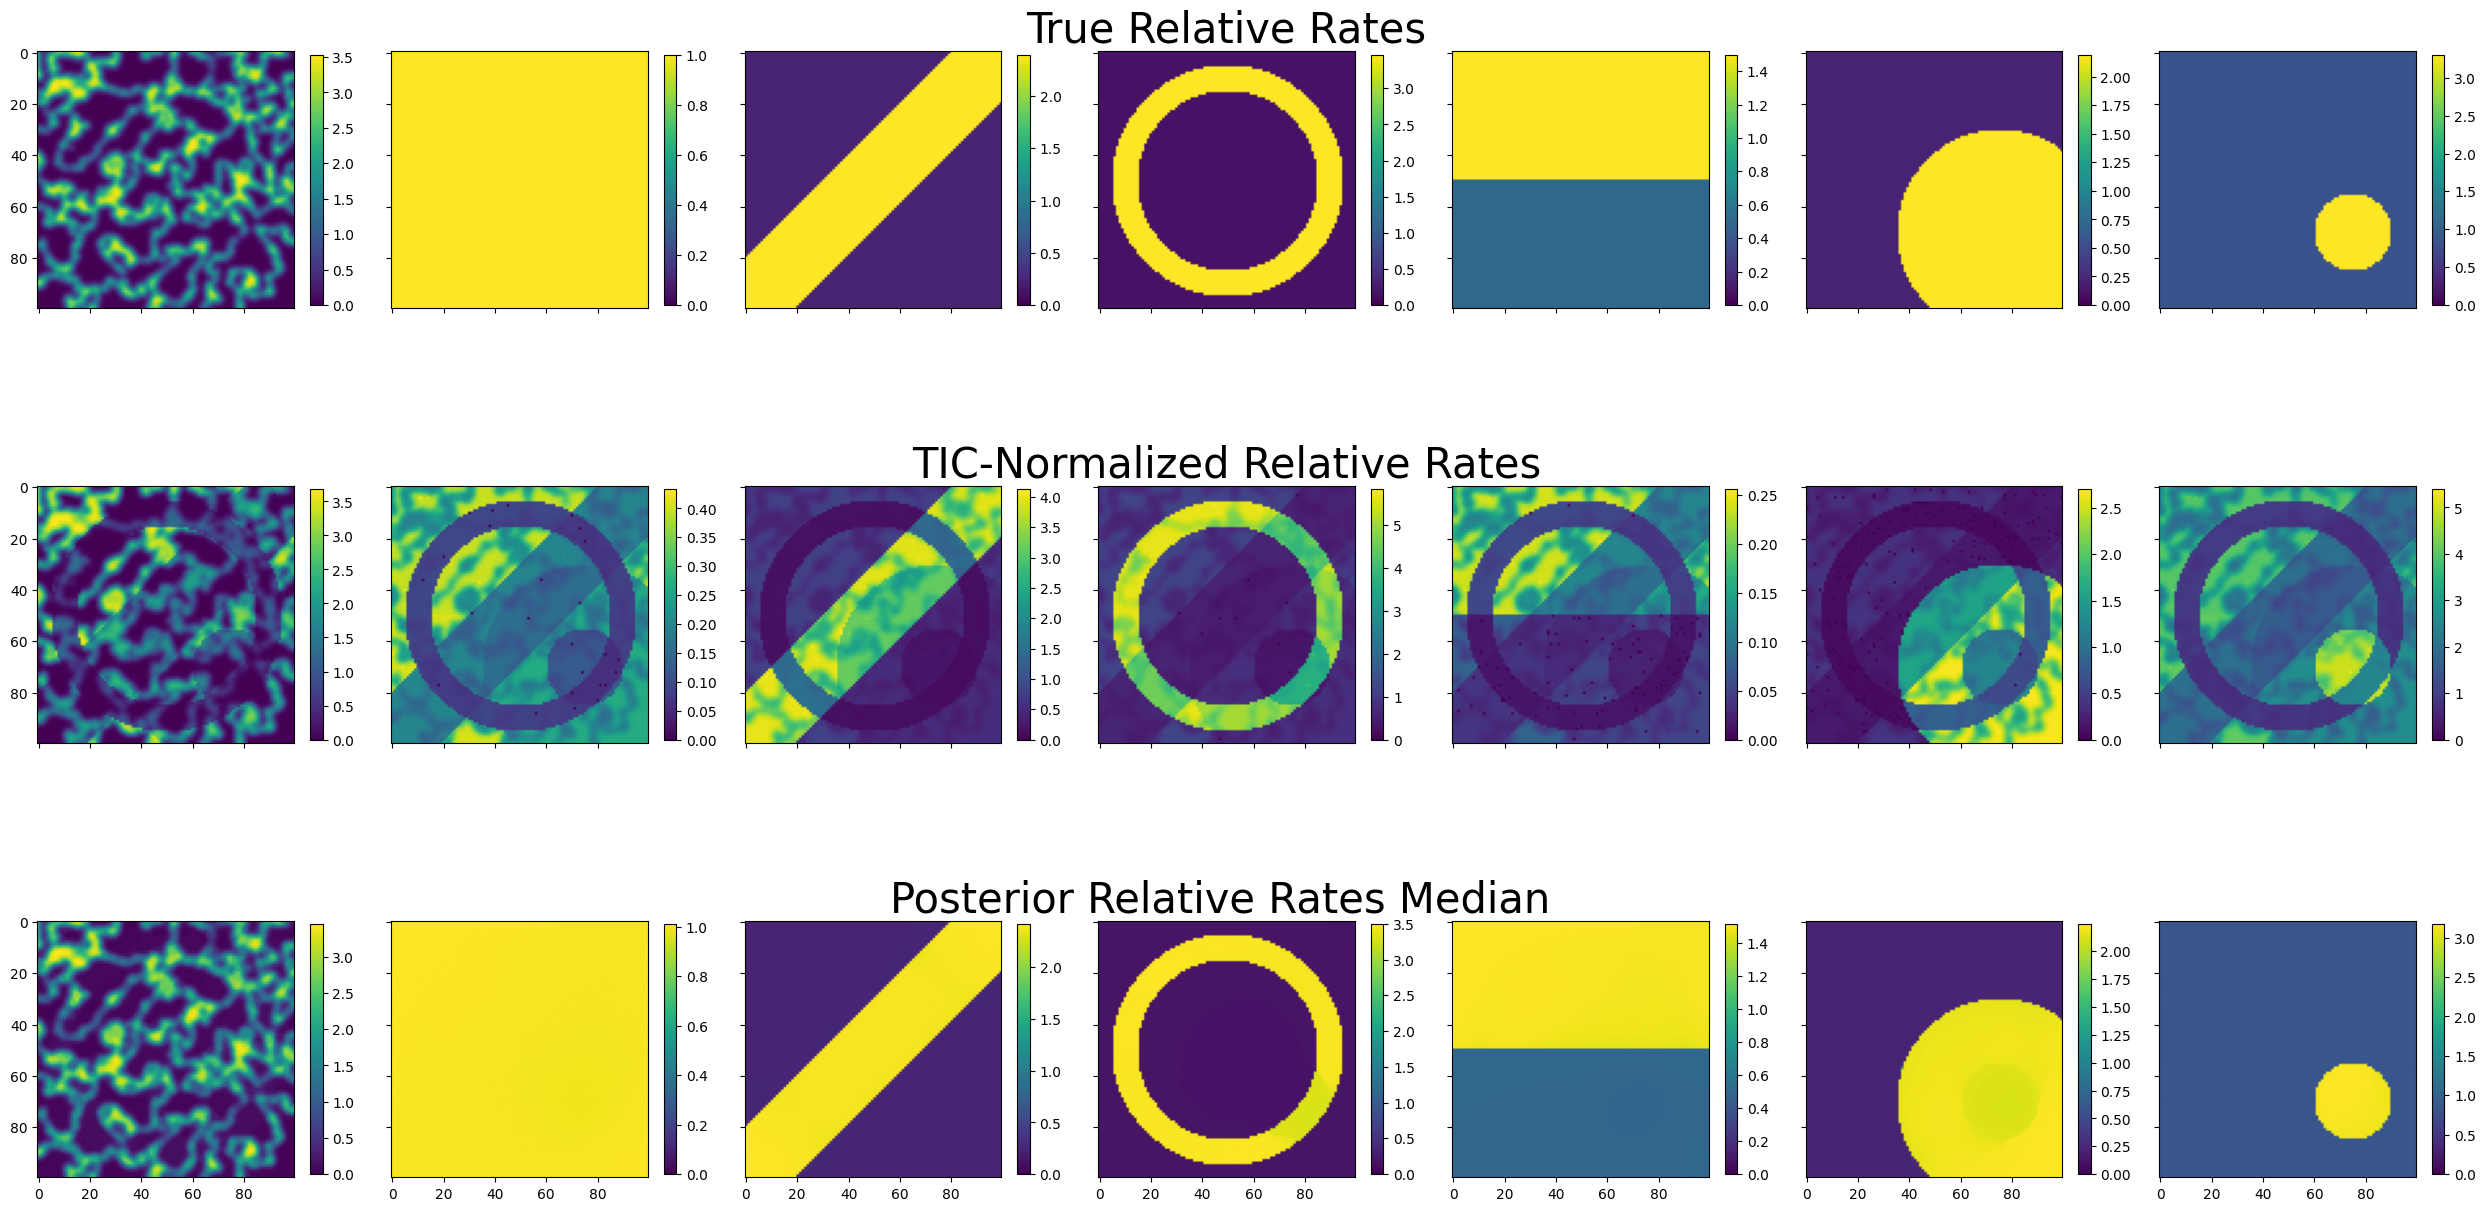

In [ ]:
data=data.reshape(size*size,D)
truth = truth.reshape (size*size,D)
gdata=data.clone()
gdata[cens] = 0
tic=gdata/gdata.nansum(dim=1,keepdims=True)
truth = torch.tensor(truth)
vs = truth/torch.mean(truth,dim=0)



#q_theta = torch.distributions.Normal(model1['theta_q_loc'].cpu(),model1['theta_q_sd'].cpu().exp())

#samps_q = q_theta.sample([1]).squeeze(0)
#samps_q=samps_q.flatten(0,1)
#quants = torch.quantile((samps_q.exp()/torch.mean(samps_q.exp(), dim = (1),keepdims=True)),q=torch.tensor([0.05,0.25,0.5,0.75,0.95], dtype=torch.float32,device=device), dim=0)

alpha =(theta_q_loc.detach().exp()/theta_q_loc.detach().exp().mean(axis=0,keepdims=True)).cpu()
vs = vs.to(device)
data=data.reshape (size,size,D)
tic2=tic/torch.nanmean(tic,dim=(0,1))
tic2=tic2.reshape(size,size,D)
truth=truth.reshape (size,size,D)
alpha=alpha.reshape (size,size,D)
vs= vs.to(device)

vs2=vs.reshape(size,size,D)

fig, axarr = plt.  subplots(3, truth.shape[2], figsize=(25, truth.shape[2]*2), sharex=True, sharey=True)

axarr[0, 3].set_title('True Relative Rates', fontsize=30)
axarr[1, 3].set_title('TIC-Normalized Relative Rates', fontsize=30)
axarr[2, 3].set_title('Posterior Relative Rates Median ', fontsize=30)

for j in range(truth.shape[2]):
    ax1 = axarr[0, j].imshow(vs2[..., j].cpu(), vmin=0, vmax=vs2[...,j].max().cpu())
    ax2 = axarr[1, j].imshow(tic2[..., j].cpu(), vmin=0, vmax=tic2[...,j].max().cpu())
    ax3 = axarr[2, j].imshow(alpha[..., j].cpu(), vmin=0, vmax=alpha[...,j].max().cpu())

    fig.colorbar(ax1, ax=axarr[0, j], shrink = 0.5)
    fig.colorbar(ax2, ax=axarr[1, j], shrink = 0.5)
    fig.colorbar(ax3, ax=axarr[2, j], shrink = 0.5)

plt.tight_layout()
plt.savefig("Figure_1_different_scales.png", dpi=300, bbox_inches="tight")
tic=gdata/gdata.nansum(dim=1,keepdims=True)
tic2=tic/torch.nanmean(tic,dim=0)

rmse_tic = (tic2-vs).pow(2).mean(axis=[0]).sqrt()
alpha=alpha.reshape (size*size,D)

rmse_VI = (alpha-vs.cpu()).pow(2).mean(axis=[0]).sqrt()
print("RMSE for TIC: ", rmse_tic)
print ("RMSE for Posterior Median: ", rmse_VI)



In [ ]:
model1 = {
'step': step,
'theta_q_loc': theta_q_loc.detach().cpu(),
'lam_1_raw': lam_1_raw.detach().cpu(),
'lam_2_raw': lam_2_raw.detach().cpu(),
'theta_q_sd': theta_q_sd.detach().cpu(),
'optimizer_state_dict': optimizer.state_dict(),
'loss': loss.item()
}

In [ ]:
def sample_neg_mult_gamma_cont_cens (n,p,size,cens):
    p0 = 1-(p*(cens)).sum(axis=-1)
    n_sample = torch.distributions.Gamma(n,1/(1/(p0+ 1e-40)-1) + 1e-40).rsample([size])

    val = (n_sample/((1-p0+1e-40))).unsqueeze(-1)*(p*(cens)).unsqueeze(0)
    tst = torch.distributions.Normal(val, torch.sqrt(val+1e-40)).rsample()
    return(tst)

def elbo_lasso_cens_MF(theta_q_loc, x, lam, adj, cens, lods, cr, samp_size, n_samp, cens_exp, gamma_1_raw, gamma_2_raw, lam_1_raw, lam_2_raw, dat_exp, cens_inf,theta_q_sd):

    q_lam = torch.distributions.Gamma(torch.exp(lam_1_raw), torch.exp(lam_2_raw))
    lam_samp = q_lam.rsample([n_samp])
    q_gamma = torch.distributions.Gamma(torch.exp(gamma_1_raw), torch.exp(gamma_2_raw))
    q_gamma_samp = q_gamma.rsample([n_samp])


    theta_q = torch.distributions.Normal(theta_q_loc, torch.exp(theta_q_sd))
    samps_q = theta_q.rsample([n_samp])
    theta = torch.softmax(samps_q,dim=-1)
    wot = sample_neg_mult_gamma_cont_cens(dat_exp.sum(axis=-1)[:,~cr], theta[:,~cr,:], samp_size, cens_exp[:,~cr,:])
    soft_indicator = torch.sigmoid(1e5 * (lods[~cr] - wot))
    vals = (((torch.sigmoid(1e5 * (soft_indicator.mean(axis=-1) - 1))) * 2.).mean(axis=0) + 1e-90).log()

    log_theta = samps_q - torch.logsumexp(samps_q-cens_inf, axis=-1).unsqueeze(-1)
    log_likelihood = (dat_exp[~cens_exp] * log_theta[~cens_exp]).sum() / n_samp


    log_likelihood = log_likelihood + vals.sum(axis=1).mean()

    mu = (samps_q[:, adj[:, 0], :] - samps_q[:, adj[:, 1], :]).unsqueeze(0)
    laplace_prior = -(((mu.abs()* (1 / q_gamma_samp.unsqueeze(1))).sum([-1, -2])).mean())
    local_prior = -(q_gamma_samp / lam_samp.unsqueeze(1)).sum([-1, -2]).mean()

    ent_gamma = q_gamma.log_prob(q_gamma_samp).sum([-1, -2]).mean()
    ent_norm = theta_q.log_prob(samps_q).sum([-1, -2]).mean()

    lam_prior = torch.distributions.Gamma(1, lam)
    lam_kl = torch.distributions.kl_divergence(q_lam, lam_prior)
    return log_likelihood + laplace_prior + local_prior - ent_norm - ent_gamma - lam_kl.sum()


In [ ]:
import torch
import matplotlib.pyplot as plt
import time

# Example reshaping
data = data.reshape(size * size, D).to(device)
scales =  [1000*1, 1000*10, 1000*100]
data=data.reshape(size*size,D)
data=data.to(torch.float32)
pd = data.clone()
lam_use = data.mean(axis=0).cpu()

theta_q_loc = torch.tensor(((pd+1)/(pd+D).sum(axis=1,keepdims=True)+1e-3).log().clone().to(torch.float32),device=device,requires_grad=True)
theta_q_sd = torch.tensor(torch.ones_like(data)*.1,device=device,requires_grad=True)


gamma_1_raw = torch.tensor(torch.ones((edges_unique.size(0),data.size(1)), dtype=torch.float32)*(1.),device=device,requires_grad=True)
gamma_2_raw = torch.tensor(torch.ones((edges_unique.size(0),data.size(1)), dtype=torch.float32)*(lam_use).log(),device=device,requires_grad=True)

lam_1_raw = torch.zeros_like(lam_use,device=device, requires_grad=True)
lam_2_raw = torch.tensor(torch.ones_like(lam_use,dtype=torch.float64)*lam_use.log(),device=device, requires_grad=True)
lam_group = data.var(axis=0)
# --- Setup & Optimization ---
num_steps = 25000
samp_size = 100
n_samp = 2
losses = []

data = data.to(device)
cens = cens.to(device)
cens_inf = cens_inf.to(device)
edges_unique = edges_unique.to(device)
cr = [x.to(device) for x in cr]
ct = [x.to(device) for x in ct]
dat_exp = data.unsqueeze(0).expand(n_samp, -1, -1).to(device)
cens_exp = cens.unsqueeze(0).expand(n_samp, -1, -1).to(device)

lam_group = lam_group.to(device)

N = edges_unique.max().item() + 1
sums = torch.zeros(n_samp, N, gamma_2_raw.size(-1), dtype=torch.float32, device=device)
a1 = edges_unique[:, 0].unsqueeze(0).unsqueeze(-1).expand(n_samp, -1, gamma_2_raw.size(-1))
a2 = edges_unique[:, 1].unsqueeze(0).unsqueeze(-1).expand(n_samp, -1, gamma_2_raw.size(-1))
#k_raw = (torch.ones(data.size(1), dtype=torch.float32))*(-10.)
#k_raw[1] = 10.
#k_raw = torch.tensor(k_raw, dtype=torch.float32, device=device, requires_grad=True)
optimizer = torch.optim.Adam([theta_q_loc, gamma_1_raw, gamma_2_raw, lam_1_raw, lam_2_raw, theta_q_sd], lr=0.01)
# --- Training Loop ---
TH = 1e12
for step in range(num_steps):

    optimizer.zero_grad()

    loss = -elbo_lasso_cens_MF(
        theta_q_loc=theta_q_loc, x=data, lam=lam_group, adj=edges_unique,
        cens=cens, lods=lods, cr=cr[0],
        samp_size=samp_size, n_samp=n_samp, cens_exp=cens_exp, gamma_1_raw=gamma_1_raw, gamma_2_raw=gamma_2_raw,
        lam_1_raw=lam_1_raw, lam_2_raw=lam_2_raw, dat_exp=dat_exp,  cens_inf = cens_inf,theta_q_sd=theta_q_sd)

    loss.backward()

    optimizer.step()

    losses.append(loss.item())

    with torch.no_grad():
      if step !=0:
        if step != 5000:
          if step % 5000 == 0:
            print(step)
            data=data.reshape(size*size,D)
            truth = truth.reshape (size*size,D)
            gdata=data.clone()
            gdata[cens]=torch.nan
            tic=gdata/gdata.nansum(dim=1,keepdims=True)
            truth = torch.tensor(truth)
            vs = truth/torch.mean(truth,dim=0)



            q_theta = torch.distributions.Normal(theta_q_loc,theta_q_sd.exp())

            samps_q = q_theta.sample([100])
            quants = torch.quantile((samps_q.exp()/torch.mean(samps_q.exp(), dim = (1),keepdims=True)),q=torch.tensor([0.05,0.25,0.5,0.75,0.95], dtype=torch.float32,device=device), dim=0)


            alpha = quants[2]
            gdata=data.clone()
            gdata[cens] = lods[cens].to(dtype=torch.float32)/2
            tic=gdata/gdata.nansum(dim=1,keepdims=True)
            tic2=tic/torch.nanmean(tic,dim=0)
            vs = vs.to(device)
            rmse_tic = (tic2-vs).pow(2).mean(axis=[0]).sqrt()

            rmse_VI = (quants[2]-vs).pow(2).mean(axis=[0]).sqrt()
            print("RMSE for TIC: ", rmse_tic)
            print ("RMSE for Posterior Median: ", rmse_VI)
            CI_50 = ((vs<=quants[3])*(vs>=quants[1])).sum(axis=0)/(size*size)
            print("50% Credible Interval Coverage: ", CI_50)
            CI_90 = ((vs<=quants[4])*(vs>=quants[0])).sum(axis=0)/(size*size)
            print("90% Credible Interval Coverage: ", CI_90)
            print ((quants[4] - quants[0]).mean(axis=0))
outfile_name = sim_name + 'MF_model_simulation.pt'
torch.save({
'step': step,
'theta_q_loc': theta_q_loc.detach().cpu(),
'gamma_1_raw': gamma_1_raw.detach().cpu(),
'gamma_2_raw': gamma_2_raw.detach().cpu(),
'lam_1_raw': lam_1_raw.detach().cpu(),
'lam_2_raw': lam_2_raw.detach().cpu(),
'theta_q_sd': theta_q_sd.detach().cpu(),
'optimizer_state_dict': optimizer.state_dict(),
'loss': loss.item()
}, outfile_name)

<ipython-input-95-53b21f5fa056>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_q_loc = torch.tensor(((pd+1)/(pd+D).sum(axis=1,keepdims=True)+1e-3).log().clone().to(torch.float32),device=device,requires_grad=True)
<ipython-input-95-53b21f5fa056>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_q_sd = torch.tensor(torch.ones_like(data)*.1,device=device,requires_grad=True)
<ipython-input-95-53b21f5fa056>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gamma_1_raw = torch.tensor(torch.ones((edges_unique.size(0),data.size(1))

10000
RMSE for TIC:  tensor([1.1912, 0.9733, 1.1844, 1.3999, 1.1051, 1.2506, 0.9149],
       device='cuda:0', dtype=torch.float64)
RMSE for Posterior Median:  tensor([0.1441, 0.0959, 0.0500, 0.1661, 0.1200, 0.0489, 0.1048],
       device='cuda:0', dtype=torch.float64)
50% Credible Interval Coverage:  tensor([0.0612, 0.0330, 0.0472, 0.0402, 0.0211, 0.0662, 0.0563],
       device='cuda:0')
90% Credible Interval Coverage:  tensor([0.1449, 0.0800, 0.1153, 0.1015, 0.0484, 0.1661, 0.1271],
       device='cuda:0')
tensor([0.0439, 0.0264, 0.0263, 0.0287, 0.0224, 0.0242, 0.0315],
       device='cuda:0')


<ipython-input-95-53b21f5fa056>:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  truth = torch.tensor(truth)


15000
RMSE for TIC:  tensor([1.1912, 0.9733, 1.1844, 1.3999, 1.1051, 1.2506, 0.9149],
       device='cuda:0', dtype=torch.float64)
RMSE for Posterior Median:  tensor([0.0247, 0.0016, 0.0021, 0.0031, 0.0018, 0.0020, 0.0024],
       device='cuda:0', dtype=torch.float64)
50% Credible Interval Coverage:  tensor([0.2106, 0.2152, 0.2095, 0.2198, 0.1830, 0.1647, 0.2616],
       device='cuda:0')
90% Credible Interval Coverage:  tensor([0.4615, 0.4794, 0.4820, 0.5034, 0.4213, 0.3819, 0.5725],
       device='cuda:0')
tensor([0.0121, 0.0020, 0.0023, 0.0026, 0.0018, 0.0020, 0.0029],
       device='cuda:0')
20000
RMSE for TIC:  tensor([1.1912, 0.9733, 1.1844, 1.3999, 1.1051, 1.2506, 0.9149],
       device='cuda:0', dtype=torch.float64)
RMSE for Posterior Median:  tensor([0.0250, 0.0009, 0.0012, 0.0016, 0.0011, 0.0012, 0.0012],
       device='cuda:0', dtype=torch.float64)
50% Credible Interval Coverage:  tensor([0.0806, 0.1062, 0.0662, 0.0571, 0.1262, 0.0635, 0.0679],
       device='cuda:0')
90% Cre